In [48]:
import numpy as np
import pandas as pd
import sys
import json
import os
import copy
import matplotlib.pyplot as plt
import scipy

Make `WMPL` directory visible:

In [2]:
sys.path.append('../../')

Import WMPL files:

In [3]:
import source.WesternMeteorPyLib.wmpl.MetSim.MetSim as metsim
import source.WesternMeteorPyLib.wmpl.MetSim.FitSim as fitsim
import source.WesternMeteorPyLib.wmpl.MetSim.GUI as gui
import source.WesternMeteorPyLib.wmpl.MetSim.MetSimErosion as erosion

In [232]:
class MetSimObj():
    def __init__(self, traj_path, const_json_file):
        # Init an axis for the electron line density
        # self.electronDensityPlot = self.magnitudePlot.canvas.axes.twiny()
        self.electron_density_plot_show = False
        ### Wake parameters ###
        self.wake_on = False
        self.wake_show_mass_bins = False
        self.wake_ht_current_index = 0
        self.current_wake_container = None
        # if self.wake_heights is not None:
        #     self.wake_plot_ht, self.current_wake_container = self.wake_heights[self.wake_ht_current_index]
        # else:
        #     self.wake_plot_ht = self.traj.rbeg_ele # m
        self.wake_normalization_method = 'area'
        self.wake_align_method = 'none'
        self.magnitudePlotWakeLines = None
        self.magnitudePlotWakeLineLabels = None
        self.velocityPlotWakeLines = None
        self.lagPlotWakeLines = None
        self.usg_data, self.traj = gui.loadUSGInputFile(*os.path.split(traj_path))
        self.dir_path = os.path.dirname(traj_path)
        # Disable different density after erosion change
        self.erosion_different_rho = False
        # Disable different ablation coeff after erosion change
        self.erosion_different_sigma = False
        # Disable different erosion coeff after disruption at the beginning
        self.disruption_different_erosion_coeff = False
        # Fragmentation object
        self.fragmentation = None
        self.simulation_results = None
        self.const_prev = None
        self.simulation_results_prev = None
        self.const = erosion.Constants()
        self.const.P_0m = self.usg_data.P_0m_bolo
        # If a JSON file with constant was given, load them instead of initing from scratch
        if const_json_file is not None:
            # Load the constants from the JSON files
            self.const, const_json = gui.loadConstants(const_json_file)
            # Init the fragmentation container for the GUI
            if len(self.const.fragmentation_entries):
                self.fragmentation = gui.FragmentationContainer(self, \
                    os.path.join(self.dir_path, self.const.fragmentation_file_name))
                self.fragmentation.fragmentation_entries = self.const.fragmentation_entries
                # Overwrite the existing fragmentatinon file
                # self.fragmentation.writeFragmentationFile()
            # Check if the disruption erosion coefficient is different than the main erosion coeff
            if const_json['disruption_erosion_coeff'] != const_json['erosion_coeff']:
                self.disruption_different_erosion_coeff = True
            # Check if the density is changed after Hchange
            if 'erosion_rho_change' in const_json:
                if const_json['erosion_rho_change'] != const_json['rho']:
                    self.erosion_different_rho = True
            # Check if the ablation coeff is changed after Hchange
            if 'erosion_sigma_change' in const_json:
                if const_json['erosion_sigma_change'] != const_json['sigma']:
                    self.erosion_different_sigma = True
        else:
            raise('no json file!')

        ### Calculate atmosphere density coeffs (down to the bottom observed height, limit to 15 km) ###

        # Determine the height range for fitting the density
        self.dens_fit_ht_beg = self.const.h_init
        self.dens_fit_ht_end = self.traj.rend_ele - 5000
        if self.dens_fit_ht_end < 14000:
            self.dens_fit_ht_end = 14000

        # Fit the polynomail describing the density
        dens_co = gui.MetSimGUI.fitAtmosphereDensity(self, self.dens_fit_ht_beg, self.dens_fit_ht_end)
        self.const.dens_co = dens_co

        # run the simulation
        self.runSimulationGUI(const_json)


    def runSimulationGUI(self, const_json):
            """ Run the simulation and show the results. """
            # If the fragmentation is turned on and no fragmentation data is given, notify the user
            if self.const.fragmentation_on and (self.fragmentation is None):
                frag_error_message = QMessageBox(QMessageBox.Critical, "Fragmentation file error", \
                    "Fragmentation is enabled but no fragmentation file is set.")
                frag_error_message.setInformativeText("Either load an existing fragmentation file or create a new one.")
                frag_error_message.exec_()
                return None   
            # Load fragmentation entries if fragmentation is enabled
            if self.const.fragmentation_on:
    
                # Load the file
                self.fragmentation.loadFragmentationFile()
    
                # Sort entries by height
                self.fragmentation.sortByHeight()
    
                # Reset the status of all fragmentations
                self.fragmentation.resetAll()
    
                # Write the fragmentation file
                # self.fragmentation.writeFragmentationFile()
            # Store previous run results
            # self.const_prev = copy.deepcopy(self.const)
            # self.simulation_results_prev = copy.deepcopy(self.simulation_results)

            #### TODO: replace readinputboxes with reading the values from the json

            self.const.dt = const_json.get('dt')
            self.const.P_0m = const_json.get('P_0m')
            self.const.h_init = const_json.get('h_init')
            self.const.m_kill = const_json.get('m_kill')
            self.const.v_kill = const_json.get('v_kill')
            self.const.h_kill = const_json.get('h_kill')
            self.const.len_kill = const_json.get('len_kill')
            self.const.rho = const_json.get('rho')
            self.const.rho_grain = const_json.get('rho_grain')
            self.const.m_init = const_json.get('m_init')
            self.const.sigma = const_json.get('sigma')
            self.const.v_init = const_json.get('v_init')
            self.const.shape_factor = const_json.get('shape_factor')
            self.const.gamma = const_json.get('gamma')
            self.const.zenith_angle = const_json.get('zenith_angle')
            self.const.lum_eff = const_json.get('lum_eff')
            self.const.lum_eff_type = const_json.get('lum_eff_type')
            self.const.erosion_height_start = const_json.get('erosion_height_start')
            self.const.erosion_bins_per_10mass = const_json.get('erosion_bins_per_10mass')
            self.const.erosion_coeff = const_json.get('erosion_coeff')
            self.const.erosion_height_change = const_json.get('erosion_height_change')
            self.const.erosion_coeff_change = const_json.get('erosion_coeff_change')
            self.const.erosion_mass_index = const_json.get('erosion_mass_index')
            self.const.erosion_mass_min = const_json.get('erosion_mass_min')
            self.const.erosion_mass_max = const_json.get('erosion_mass_max')
            self.const.erosion_rho_change = const_json.get('rho')
            self.const.erosion_sigma_change = const_json.get('sigma')
            self.const.compressive_strength = const_json.get('compressive_strength')
            self.const.disruption_erosion_coeff = const_json.get('erosion_coeff')
            self.const.disruption_mass_grain_ratio = const_json.get('disruption_mass_grain_ratio')
            self.const.disruption_mass_index = const_json.get('disruption_mass_index')
            self.const.disruption_mass_min_ratio = const_json.get('disruption_mass_min_ratio')
            self.const.disruption_mass_max_ratio = const_json.get('disruption_mass_max_ratio')
            # fragmentation
            self.const.fragmentation_on = const_json.get('fragmentation_on')
    
            # # Disable the simulation button (have to force update by calling "repaint")
            # self.runSimButton.setStyleSheet("background-color: red")
            # self.runSimButton.setDisabled(True)
            # self.repaint()
            # print('Running simulation...')
            # t1 = time.time()
    
            # Run the simulation
            frag_main, results_list, wake_results = erosion.runSimulation(self.const, compute_wake=self.wake_on)
            print(results_list)

            # Store simulation results
            self.simulation_results = gui.SimulationResults(self.const, frag_main, results_list, wake_results)
    
            # # Save simulated parametrs to file
            # self.simulation_results.writeCSV(self.dir_path, SIM_RESULTS_CSV)
            # print("Saved simulation results to:", os.path.join(self.dir_path, SIM_RESULTS_CSV))
    
            # # Toggle lum eff button to only be available if lum eff was computed
            # self.plotLumEffButton.setDisabled(not self.const.fragmentation_show_individual_lcs)
    
            # # Write results in the fragmentation file
            # if self.const.fragmentation_on:
            #     self.fragmentation.writeFragmentationFile()
    
            # # Update the plots
            # self.showCurrentResults()
    
            # # Save the latest run parameters
            # self.saveFitParameters(False, suffix="_latest")
    
            # # Enable the simulation button
            # self.runSimButton.setDisabled(False)
            # self.runSimButton.setStyleSheet("background-color: #b1eea6")

WIP modified version:

In [234]:
class MetSimObj_mod():
    def __init__(self, traj_path, const_json_file):
        # Init an axis for the electron line density
        # self.electronDensityPlot = self.magnitudePlot.canvas.axes.twiny()
        self.electron_density_plot_show = False
        ### Wake parameters ###
        self.wake_on = False
        self.wake_show_mass_bins = False
        self.wake_ht_current_index = 0
        self.current_wake_container = None
        # if self.wake_heights is not None:
        #     self.wake_plot_ht, self.current_wake_container = self.wake_heights[self.wake_ht_current_index]
        # else:
        #     self.wake_plot_ht = self.traj.rbeg_ele # m
        self.wake_normalization_method = 'area'
        self.wake_align_method = 'none'
        self.magnitudePlotWakeLines = None
        self.magnitudePlotWakeLineLabels = None
        self.velocityPlotWakeLines = None
        self.lagPlotWakeLines = None
        self.usg_data, self.traj = gui.loadUSGInputFile(*os.path.split(traj_path))
        self.dir_path = os.path.dirname(traj_path)
        # Disable different density after erosion change
        self.erosion_different_rho = False
        # Disable different ablation coeff after erosion change
        self.erosion_different_sigma = False
        # Disable different erosion coeff after disruption at the beginning
        self.disruption_different_erosion_coeff = False
        # Fragmentation object
        self.fragmentation = None
        self.simulation_results = None
        self.const_prev = None
        self.simulation_results_prev = None
        self.const = erosion.Constants()  # initialize this, these will be replaced later
        self.const.P_0m = self.usg_data.P_0m_bolo
        # If a JSON file with constant was given, load them instead of initing from scratch
        if const_json_file is not None:
            # Load the constants from the JSON files
            self.const, const_json = gui.loadConstants(const_json_file)
            # Init the fragmentation container for the GUI
            if len(self.const.fragmentation_entries):
                self.fragmentation = gui.FragmentationContainer(self, \
                    os.path.join(self.dir_path, self.const.fragmentation_file_name))
                self.fragmentation.fragmentation_entries = self.const.fragmentation_entries
                # Overwrite the existing fragmentatinon file
                # self.fragmentation.writeFragmentationFile()
            # Check if the disruption erosion coefficient is different than the main erosion coeff
            if const_json['disruption_erosion_coeff'] != const_json['erosion_coeff']:
                self.disruption_different_erosion_coeff = True
            # Check if the density is changed after Hchange
            if 'erosion_rho_change' in const_json:
                if const_json['erosion_rho_change'] != const_json['rho']:
                    self.erosion_different_rho = True
            # Check if the ablation coeff is changed after Hchange
            if 'erosion_sigma_change' in const_json:
                if const_json['erosion_sigma_change'] != const_json['sigma']:
                    self.erosion_different_sigma = True
        else:
            raise('no json file!')

        ### Calculate atmosphere density coeffs (down to the bottom observed height, limit to 15 km) ###

        # Determine the height range for fitting the density
        self.dens_fit_ht_beg = self.const.h_init
        self.dens_fit_ht_end = self.traj.rend_ele - 5000
        if self.dens_fit_ht_end < 14000:
            self.dens_fit_ht_end = 14000

        # Fit the polynomail describing the density
        dens_co = gui.MetSimGUI.fitAtmosphereDensity(self, self.dens_fit_ht_beg, self.dens_fit_ht_end)
        self.const.dens_co = dens_co

        # get global parameters from json file, everything other than params marked "free" are fixed
        dt = const_json.get('dt')
        P_0m = const_json.get('P_0m')
        h_init = const_json.get('h_init')
        m_kill = const_json.get('m_kill')
        v_kill = const_json.get('v_kill')
        h_kill = const_json.get('h_kill')
        len_kill = const_json.get('len_kill') 
        rho = const_json.get('rho')  # free
        rho_grain = const_json.get('rho_grain')  # free
        m_init = const_json.get('m_init')  # free
        sigma = const_json.get('sigma')  # free
        v_init = const_json.get('v_init')
        shape_factor = const_json.get('shape_factor')
        gamma = const_json.get('gamma')
        zenith_angle = const_json.get('zenith_angle')
        lum_eff = const_json.get('lum_eff')
        lum_eff_type = const_json.get('lum_eff_type')
        erosion_height_start = const_json.get('erosion_height_start')
        erosion_bins_per_10mass = const_json.get('erosion_bins_per_10mass')
        erosion_coeff = const_json.get('erosion_coeff')
        erosion_height_change = const_json.get('erosion_height_change')
        erosion_coeff_change = const_json.get('erosion_coeff_change')
        erosion_mass_index = const_json.get('erosion_mass_index')
        erosion_mass_min = const_json.get('erosion_mass_min')
        erosion_mass_max = const_json.get('erosion_mass_max')
        erosion_rho_change = const_json.get('rho')
        erosion_sigma_change = const_json.get('sigma')
        compressive_strength = const_json.get('compressive_strength')
        disruption_erosion_coeff = const_json.get('erosion_coeff')
        disruption_mass_grain_ratio = const_json.get('disruption_mass_grain_ratio')
        disruption_mass_index = const_json.get('disruption_mass_index')
        disruption_mass_min_ratio = const_json.get('disruption_mass_min_ratio')
        disruption_mass_max_ratio = const_json.get('disruption_mass_max_ratio')

        # get fragmentation parameters from json file
        # type, height, number, gamma, mass index are fixed, 
        # mass, ablation coefficient, erosion coefficient, grain min, grain max are not fixed
        num_frags = len(const_json.get('fragmentation_entries'))
        # fixed
        frag_types = np.zeros(num_frags, str)
        frag_heights = np.zeros(num_frags)
        frag_numbers = np.zeros(num_frags)
        frag_gammas = np.zeros(num_frags)
        # free
        frag_mis = np.zeros(num_frags)
        frag_masses = np.zeros(num_frags)
        frag_ab_coeffs = np.zeros(num_frags)
        frag_er_coeffs = np.zeros(num_frags)
        frag_grain_mins = np.zeros(num_frags)
        frag_grain_maxs = np.zeros(num_frags)

        for i, frag in enumerate(const_json.get('fragmentation_entries')):
            # fixed
            frag_types[i] = frag['frag_type']
            frag_heights[i] = frag['height']
            frag_numbers[i] = frag['number']
            frag_gammas[i] = frag['gamma']
            frag_mis[i] = frag['mass_index']
            # free
            frag_masses[i] = frag['mass_percent']
            frag_ab_coeffs[i] = frag['sigma']
            frag_er_coeffs[i] = frag['erosion_coeff']
            frag_grain_mins[i] = frag['grain_mass_min']
            frag_grain_maxs[i] = frag['grain_mass_max']

        # set free and fixed params
        free_params = (rho, rho_grain, m_init, sigma, frag_masses, frag_ab_coeffs, frag_er_coeffs, frag_grain_mins, frag_grain_maxs)
        fixed_params = (dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, v_init, shape_factor, 
                        gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, 
                        erosion_bins_per_10mass, erosion_coeff, erosion_height_change, 
                        erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, 
                        erosion_rho_change, erosion_sigma_change, compressive_strength, 
                        disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, 
                        disruption_mass_min_ratio, disruption_mass_max_ratio, 
                        frag_types, frag_heights, frag_numbers, frag_gammas, frag_mis)
        # get all parameters
        all_params = (free_params, fixed_params)

        # load all the non-fragmentation parameters into the object
    
        self.const.dt = dt
        self.const.P_0m = P_0m
        self.const.h_init = h_init
        self.const.m_kill = m_kill
        self.const.v_kill = v_kill
        self.const.h_kill = h_kill
        self.const.len_kill = len_kill
        self.const.rho = rho
        self.const.rho_grain = rho_grain
        self.const.m_init = m_init
        self.const.sigma = sigma
        self.const.v_init = v_init
        self.const.shape_factor = shape_factor
        self.const.gamma = gamma
        self.const.zenith_angle = zenith_angle
        self.const.lum_eff = lum_eff
        self.const.lum_eff_type = lum_eff_type
        self.const.erosion_height_start = erosion_height_start
        self.const.erosion_bins_per_10mass = erosion_bins_per_10mass
        self.const.erosion_coeff = erosion_coeff
        self.const.erosion_height_change = erosion_height_change
        self.const.erosion_coeff_change = erosion_coeff_change
        self.const.erosion_mass_index = erosion_mass_index
        self.const.erosion_mass_min = erosion_mass_min
        self.const.erosion_mass_max = erosion_mass_max
        self.const.erosion_rho_change = rho
        self.const.erosion_sigma_change = sigma
        self.const.compressive_strength = compressive_strength
        self.const.disruption_erosion_coeff = erosion_coeff
        self.const.disruption_mass_grain_ratio = disruption_mass_grain_ratio
        self.const.disruption_mass_index = disruption_mass_index
        self.const.disruption_mass_min_ratio = disruption_mass_min_ratio
        self.const.disruption_mass_max_ratio = disruption_mass_max_ratio
        
        self.initializeSimulation(all_params)
        # self.initializeSimulation(const_json)


    def initializeSimulation(self, all_params):
            """ Run the simulation and show the results. """
            # If the fragmentation is turned on and no fragmentation data is given, notify the user
            # if self.const.fragmentation_on and (self.fragmentation is None):
            #     frag_error_message = QMessageBox(QMessageBox.Critical, "Fragmentation file error", \
            #         "Fragmentation is enabled but no fragmentation file is set.")
            #     frag_error_message.setInformativeText("Either load an existing fragmentation file or create a new one.")
            #     frag_error_message.exec_()
            #     return None   

            # unpack all params
            free_params, fixed_params = all_params
            # unpack again
            rho, rho_grain, m_init, sigma, frag_masses, frag_ab_coeffs, frag_er_coeffs, frag_grain_mins, frag_grain_maxs = free_params
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio, frag_types, frag_heights, frag_numbers, frag_gammas, frag_mis = fixed_params

            # Load fragmentation entries
            self.fragmentation_entries = []
            for i in range(0, len(frag_masses)):  # pick any frag entry to iterate over
                frag_entry = gui.FragmentationEntry(frag_types[i], frag_heights[i], frag_numbers[i], frag_masses[i], 
                                                    frag_ab_coeffs[i], frag_gammas[i], frag_er_coeffs[i], frag_grain_mins[i], frag_grain_maxs[i], frag_mis[i])
                self.fragmentation_entries.append(frag_entry)
            # set the fragmentation entries to constants
            self.const.fragmentation_entries = self.fragmentation_entries
    
            # Sort entries by height
            self.fragmentation.sortByHeight()

            # Reset the status of all fragmentations
            self.fragmentation.resetAll()
        
            # fragmentation
            self.const.fragmentation_on = True
    
            # Run the simulation
            frag_main, results_list, wake_results = erosion.runSimulation(self.const, compute_wake=self.wake_on)
            print(results_list)

            # Store simulation results
            self.simulation_results = gui.SimulationResults(self.const, frag_main, results_list, wake_results)


Test with 1999 event:

In [235]:
metsim_obj = MetSimObj(traj_path='../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', 
                       const_json_file='../usg_metsim_files/1999-01-14/usg_input_jan_1999_sim_fit.json')

ERROR! Cannot read fragmentation line:
 
[[0.01, 13057.406859977928, 13057.406859977928, 0.0, 3520387901880714.0, 0.05088837006540465, 0.05088837006540465, 0, 179875.1112869001, 152.00000004052717, 15200.000004052717, 179875.1112869001, 152.00000004052717, 15200.000004052717, 0.09514999218725634, 2499999.9999918677, 2499999.9999918677, 179875.1112869001, 152.00000004052717, 15200.000004052717, 0.09514999218725634], [0.02, 13255.317141454347, 13255.317141454347, 0.0, 3573746199662465.0, 0.05088837008247122, 0.05088837008247122, 0, 179750.2237202713, 304.0000001215766, 15200.00000810494, 179750.2237202713, 304.0000001215766, 15200.00000810494, 0.09659217446245674, 2499999.999983612, 2499999.999983612, 179750.2237202713, 304.0000001215766, 15200.00000810494, 0.09659217446245674], [0.03, 13454.21740562345, 13454.21740562345, 0.0, 3627371405293034.0, 0.05088837009953724, 0.05088837009953724, 0, 179625.3373001807, 456.0000002431433, 15200.00001215667, 179625.3373001807, 456.0000002431433, 15

In [236]:
metsim_obj_mod = MetSimObj_mod(traj_path='../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', 
                       const_json_file='../usg_metsim_files/1999-01-14/usg_input_jan_1999_sim_fit.json')

[[0.01, 13057.406859977928, 13057.406859977928, 0.0, 3520387901880714.0, 0.05088837006540465, 0.05088837006540465, 0, 179875.1112869001, 152.00000004052717, 15200.000004052717, 179875.1112869001, 152.00000004052717, 15200.000004052717, 0.09514999218725634, 2499999.9999918677, 2499999.9999918677, 179875.1112869001, 152.00000004052717, 15200.000004052717, 0.09514999218725634], [0.02, 13255.317141454347, 13255.317141454347, 0.0, 3573746199662465.0, 0.05088837008247122, 0.05088837008247122, 0, 179750.2237202713, 304.0000001215766, 15200.00000810494, 179750.2237202713, 304.0000001215766, 15200.00000810494, 0.09659217446245674, 2499999.999983612, 2499999.999983612, 179750.2237202713, 304.0000001215766, 15200.00000810494, 0.09659217446245674], [0.03, 13454.21740562345, 13454.21740562345, 0.0, 3627371405293034.0, 0.05088837009953724, 0.05088837009953724, 0, 179625.3373001807, 456.0000002431433, 15200.00001215667, 179625.3373001807, 456.0000002431433, 15200.00001215667, 0.09804157078992042, 249

In [227]:
vars(metsim_obj_mod.const)

{'dt': 0.01,
 'total_time': 13.79999999999975,
 'n_active': 0,
 'm_kill': 1e-14,
 'v_kill': 3000.0,
 'h_kill': 10194.0,
 'len_kill': -1000.0,
 'h_init': 180000.0,
 'P_0m': 3030.0,
 'dens_co': array([ 1.87115546e+00, -2.29830750e+02,  5.44933589e+03, -7.45154603e+04,
         4.46466261e+05, -1.01136390e+06,  3.10195739e+05]),
 'r_earth': 6367808.358943568,
 'total_fragments': 13,
 'wake_psf': 3.0,
 'wake_extension': 200.0,
 'rho': 1500.0,
 'm_init': 2500000.0,
 'v_init': 15200.0,
 'shape_factor': 0.8,
 'sigma': 5e-09,
 'zenith_angle': 0.6065193683605494,
 'gamma': 1.0,
 'rho_grain': 3500.0,
 'lum_eff_type': 7,
 'lum_eff': 0.7,
 'mu': 3.8180000000000003e-26,
 'erosion_on': False,
 'erosion_bins_per_10mass': 2,
 'erosion_height_start': 75177.0,
 'erosion_coeff': 3.3e-07,
 'erosion_height_change': 13194.0,
 'erosion_coeff_change': 3.3e-07,
 'erosion_rho_change': 1500.0,
 'erosion_sigma_change': 5e-09,
 'erosion_mass_index': 2.5,
 'erosion_mass_min': 1e-11,
 'erosion_mass_max': 5e-10,
 'di

In [206]:
vars(metsim_obj.const)

{'dt': 0.01,
 'total_time': 14.059999999999745,
 'n_active': 0,
 'm_kill': 1e-14,
 'v_kill': 3000.0,
 'h_kill': 10194.0,
 'len_kill': -1000.0,
 'h_init': 180000.0,
 'P_0m': 3030.0,
 'dens_co': array([ 1.87115546e+00, -2.29830750e+02,  5.44933589e+03, -7.45154603e+04,
         4.46466261e+05, -1.01136390e+06,  3.10195739e+05]),
 'r_earth': 6367808.358943568,
 'total_fragments': 2156,
 'wake_psf': 3.0,
 'wake_extension': 200.0,
 'rho': 1500.0,
 'm_init': 2500000.0,
 'v_init': 15200.0,
 'shape_factor': 0.8,
 'sigma': 5e-09,
 'zenith_angle': 0.6065193683605494,
 'gamma': 1.0,
 'rho_grain': 3500.0,
 'lum_eff_type': 7,
 'lum_eff': 0.7,
 'mu': 3.8180000000000003e-26,
 'erosion_on': False,
 'erosion_bins_per_10mass': 2,
 'erosion_height_start': 75177.0,
 'erosion_coeff': 3.3e-07,
 'erosion_height_change': 13194.0,
 'erosion_coeff_change': 3.3e-07,
 'erosion_rho_change': 1500.0,
 'erosion_sigma_change': 5e-09,
 'erosion_mass_index': 2.5,
 'erosion_mass_min': 1e-11,
 'erosion_mass_max': 5e-10,
 

In [192]:
from pprint import pprint

for i in range(0, len(metsim_obj.const.fragmentation_entries)):
    print(vars(metsim_obj.const.fragmentation_entries[i]) == vars(metsim_obj.const.fragmentation_entries[i]))

# metsim_obj.const.fragmentation_entries

True
True
True
True
True
True
True
True
True
True


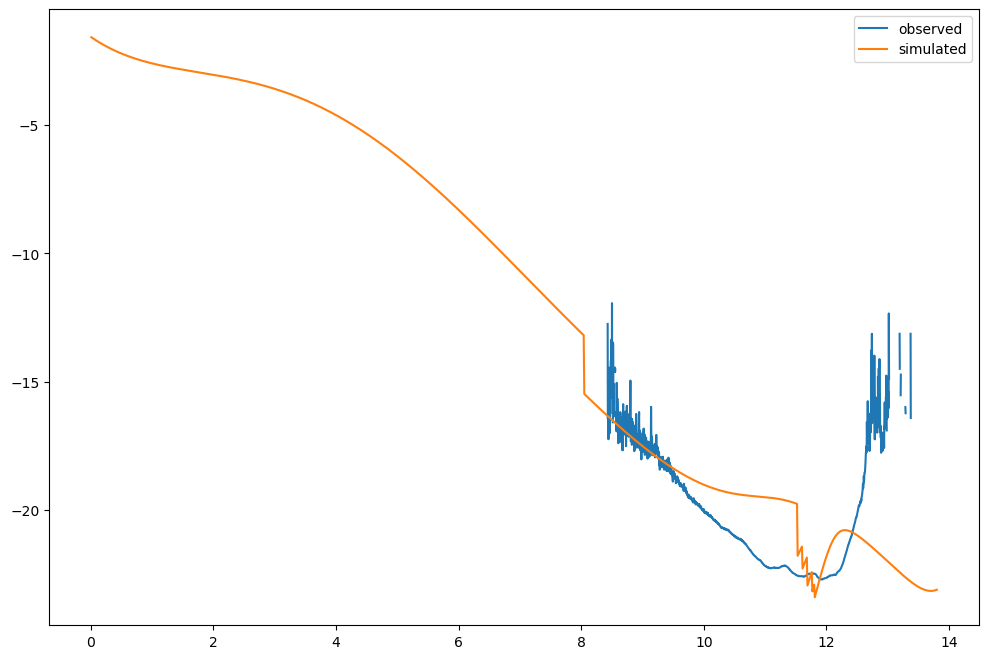

In [193]:
plt.figure(figsize = (12, 8))
plt.plot(metsim_obj_mod.usg_data.time_data + 11.9, metsim_obj_mod.usg_data.absolute_magnitudes, label = 'observed')
plt.plot(metsim_obj_mod.simulation_results.time_arr, metsim_obj_mod.simulation_results.abs_magnitude, label = 'simulated')
plt.plot(metsim_obj
plt.legend()

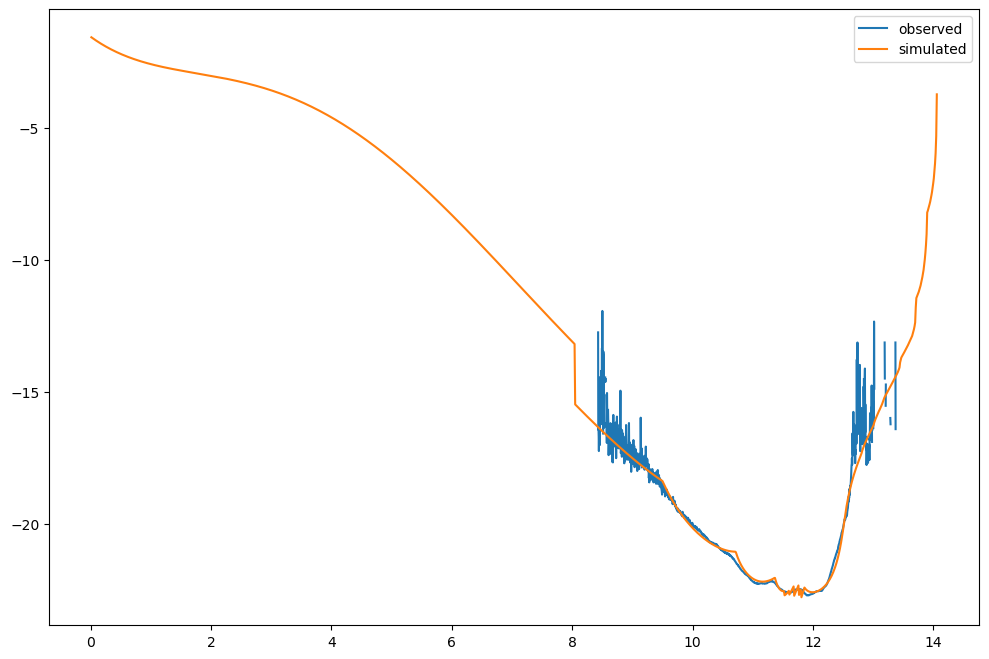

In [93]:
plt.figure(figsize = (12, 8))
plt.plot(metsim_obj.usg_data.time_data + 11.9, metsim_obj.usg_data.absolute_magnitudes, label = 'observed')
plt.plot(metsim_obj.simulation_results.time_arr, metsim_obj.simulation_results.abs_magnitude, label = 'simulated')
plt.legend()

[]

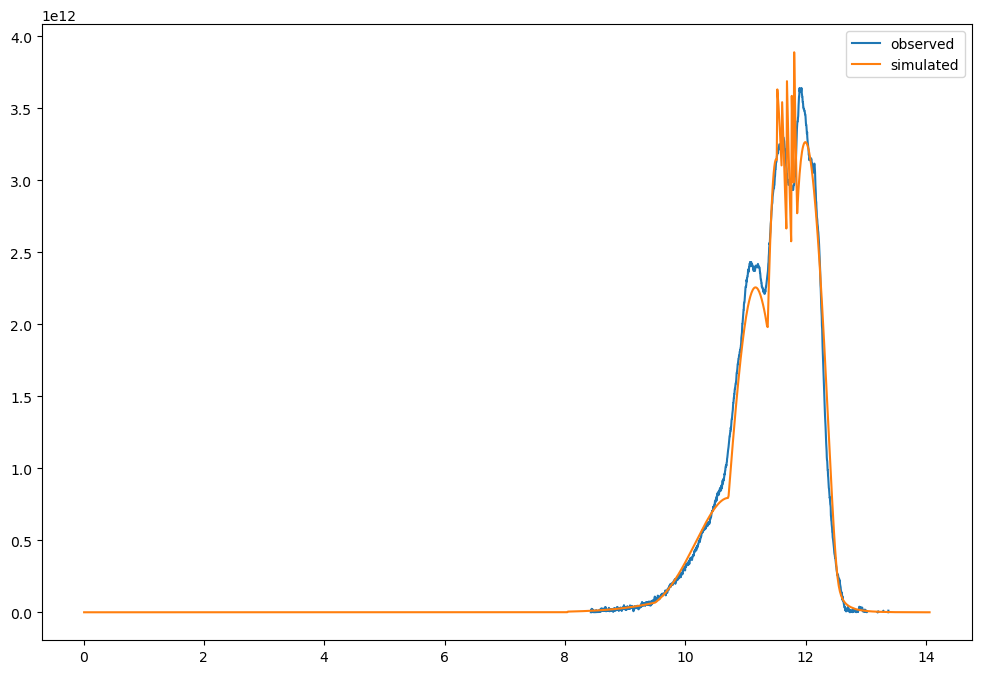

In [94]:
plt.figure(figsize = (12, 8))
plt.plot(metsim_obj.usg_data.time_data + 11.9, 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5))), label = 'observed')
plt.plot(metsim_obj.simulation_results.time_arr, metsim_obj.simulation_results.luminosity_arr, label = 'simulated')
plt.legend()
plt.plot()

In [73]:
obs_integrated_intensity = np.nansum(np.diff(metsim_obj.usg_data.time_data) * 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))[1:])
sim_integrated_intensity = np.nansum(np.diff(metsim_obj.simulation_results.time_arr) * metsim_obj.simulation_results.luminosity_arr[1:])

obs_integrated_intensity, sim_integrated_intensity

(4935296449100.806, 4838293516017.829)

In [8]:
# gui.MetSimGUI.loadFragmentationFile()

# self.fragmentation=None

In [9]:
# gui.FragmentationContainer(gui.MetSimGUI('../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', usg_input=True), 
#                            '../usg_metsim_files/1999-01-14/metsim_fragmentation.txt')

In [10]:
# gui.MetSimGUI('../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', usg_input=True)